In [1]:
import numpy as np
import csv    #加载csv包便于读取csv文件
import zipfile
import os
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import time
from datetime import timedelta

def date_2_timestamp(year,mon,day):
    tempString=str(year)+"-"+str(mon)+"-"+str(day)
    tempTime=time.strptime(tempString, "%Y-%m-%d")
    return time.mktime(tempTime)

def timestamp_2_date(un_time):
    return datetime.datetime.fromtimestamp(un_time)


def timestamp_removeDay_reduce(temp_timestamp):
    temp_date=timestamp_2_date(temp_timestamp)
    temp_timestamp=date_2_timestamp(temp_date.year,temp_date.month,1)
    return temp_timestamp

def timestamp_removeHour_reduce(temp_timestamp):
    temp_date=timestamp_2_date(temp_timestamp)
    temp_timestamp=date_2_timestamp(temp_date.year,temp_date.month,temp_date.day)
    return temp_timestamp

def timestamp_removeDay_add(temp_timestamp):
    temp_date=timestamp_2_date(temp_timestamp)
    if temp_date.month==12:
        return date_2_timestamp(temp_date.year+1,1,1)
    else:
        return date_2_timestamp(temp_date.year,temp_date.month+1,1)
    
def date_removeDay_reduce(temp_date):
    temp_timestamp=date_2_timestamp(temp_date.year,temp_date.month,1)
    return timestamp_2_date(temp_timestamp)

def date_removeHour_reduce(temp_date):
    temp_timestamp=date_2_timestamp(temp_date.year,temp_date.month,temp_date.day)
    return timestamp_2_date(temp_timestamp)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

# 返回从最小到最大之间经过的时间戳，间隔为一个月
def max_min_2_timestampList(minDate,maxDate):    
    resList=[]
    resMap={}
    for single_date in daterange(minDate, maxDate):
        temp_date=date_removeDay_reduce(single_date)
        temp_timestamp=date_2_timestamp(temp_date.year,temp_date.month,temp_date.day)
        resMap[temp_timestamp]=1 

    for key in resMap.keys():
        resList.append(key)
    
    # print(resList)
    return sorted(resList)

# 返回从最小到最大之间经过的时间戳，间隔为一天

def max_min_2_timestampList_day(minDate,maxDate):    
    resList=[]
    resMap={}
    for single_date in daterange(minDate, maxDate):
        # temp_date=date_removeHour_reduce(single_date)
        temp_timestamp=date_2_timestamp(single_date.year,single_date.month,single_date.day)
        resMap[temp_timestamp]=1 

    for key in resMap.keys():
        resList.append(key)
    
    # print(resList)
    return sorted(resList)


def timestamp_2_string(temp_timestamp):
    temp_date=datetime.datetime.fromtimestamp(temp_timestamp)
    if temp_date.month<10:
        tempMonth="0"+str(temp_date.month)
    else:
        tempMonth=str(temp_date.month)
    return str(temp_date.year)+"-"+tempMonth

import calendar
def timestamp_2_string_ymd(temp_timestamp):
    temp_date=datetime.datetime.fromtimestamp(temp_timestamp)
    # if temp_date.month<10:
    #     tempMonth="0"+str(temp_date.month)
    # else:
    #     tempMonth=str(temp_date.month)
        
    tempMonth=calendar.month_abbr[int(temp_date.month)]
        
    if temp_date.day<10:
        tempDay="0"+str(temp_date.day)
    else:
        tempDay=str(temp_date.day)
    return tempMonth+"-"+tempDay+"-"+str(temp_date.year)

In [96]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll_final.csv")
print("len df",len(df))
print("total revenue",sum(df["revenue_dollar"]))
print("total minerReward_usd",sum(df["minerReward_usd"]))


len df 28296
total revenue 10180706.660288446
total minerReward_usd 104256310.60063004


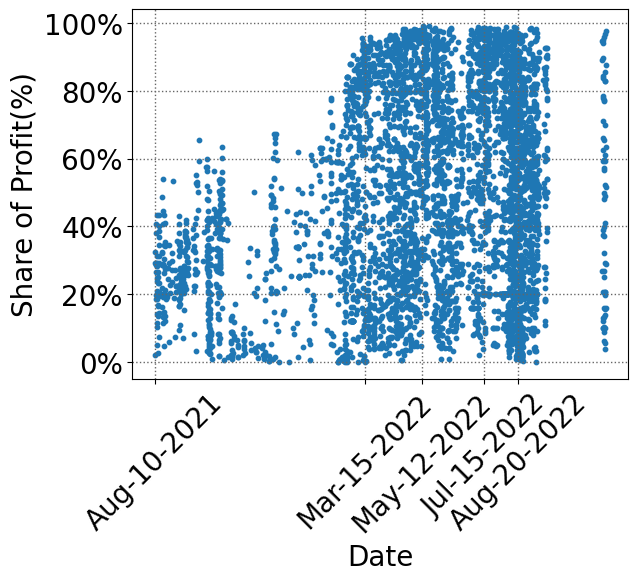

In [97]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll.csv")
# df=df[df["coinbase_transfer_usd"]<df["pureRevenue_usd"]]
df=df[df["coinbase_transfer_usd"]>0]
df=df[df["pureRevenue_usd"]>0]
df=df[df["revenue_dollar"]>0]
# df=df[df["coinbase_transfer_usd"]>df["minerReward_usd"]]

minDate=datetime.datetime.fromtimestamp( min(df["timestamp"]) )
maxDate=datetime.datetime.fromtimestamp( max(df["timestamp"]) )

tx_map={}
timestamp_map={}
for index,row in df.iterrows():
    transactionHash=row["transactionHash"]
    timestamp=int(row["timestamp"])
    
    coinbase_transfer_usd=float(row["coinbase_transfer_usd"])
    pureRevenue_usd=float(row["pureRevenue_usd"])
    
    # if coinbase_transfer_usd==0 or coinbase_transfer_usd>pureRevenue_usd:
    #     continue
    
    proportion=(coinbase_transfer_usd/pureRevenue_usd)
    tx_map[transactionHash]={"timestamp":timestamp,"proportion":proportion}
    timestamp_map[timestamp]=proportion
    
    if proportion>100:
        print(timestamp)
    
    
timestampList=list(timestamp_map.keys())
timestampList.sort()
proportionList=[]
dateList=[]
for timestamp in timestampList:
    proportionList.append(timestamp_map[timestamp])
    # dateList.append(timestamp_2_string_ymd(timestamp))
    

# x = np.arange(len(timestampList))

# plt.scatter( np.arange(len(timestampList)) ,  proportionList, s=10)
# plt.xticks(x,labels=x_key,fontsize=20,rotation=45)


x=[]
x_key=[]
for i in range(len(timestampList)):
    timestamp=timestampList[i]
    if i%1000==0:
        x.append(timestamp)
        x_key.append(timestamp_2_string_ymd(timestamp))


plt.scatter( timestampList ,  proportionList, s=10)
plt.xticks(x,labels=x_key,fontsize=20,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Share of Profit(%)', fontsize=20)
plt.xlabel('Date', fontsize=20)
from matplotlib.ticker import PercentFormatter


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.grid(True, color='#666666', linestyle = ":", linewidth = "1")

plt.savefig("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/photo/overall_shareProfit.pdf",bbox_inches='tight')

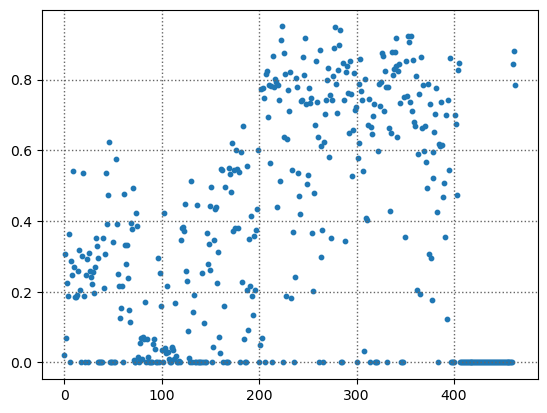

In [98]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll_final.csv")
df=df[df["coinbase_transfer_usd"]<df["pureRevenue_usd"]]
df=df[df["coinbase_transfer_usd"]!=0]
# df=df[df["coinbase_transfer_usd"]>df["minerReward_usd"]]

minDate=datetime.datetime.fromtimestamp( min(df["timestamp"]) )
maxDate=datetime.datetime.fromtimestamp( max(df["timestamp"]) )

tx_map={}
timestamp_map={}
for index,row in df.iterrows():
    transactionHash=row["transactionHash"]
    timestamp=int(row["timestamp"])
    
    timestamp=timestamp_removeHour_reduce(timestamp)
    
    coinbase_transfer_usd=float(row["coinbase_transfer_usd"])
    pureRevenue_usd=float(row["pureRevenue_usd"])
    
    if timestamp not in timestamp_map:
        timestamp_map_value={"pureRevenue_usd":pureRevenue_usd,"coinbase_transfer_usd":coinbase_transfer_usd}
    else:
        timestamp_map_value=timestamp_map[timestamp]
        timestamp_map_value["pureRevenue_usd"]+=pureRevenue_usd
        timestamp_map_value["coinbase_transfer_usd"]+=coinbase_transfer_usd
        
    timestamp_map[timestamp]=timestamp_map_value
    
new_timestamp_map={}
for timestamp,value in timestamp_map.items():
    new_timestamp_map[timestamp]=(value["coinbase_transfer_usd"]/value["pureRevenue_usd"])
    
list_key=[]
list_value=[]
for tempTimestamp in max_min_2_timestampList_day(minDate,maxDate):
    if tempTimestamp not in timestamp_map:
        new_timestamp_map[tempTimestamp]=0
    
    list_key.append(timestamp_2_string_ymd(tempTimestamp))
    list_value.append( new_timestamp_map[tempTimestamp] )
    
    
timestampList=list(new_timestamp_map.keys())
timestampList.sort()
proportionList=[]
dateList=[]
for timestamp in timestampList:
    proportionList.append(new_timestamp_map[timestamp])
    # dateList.append(timestamp_2_string_ymd(timestamp))
    

# x=[]
# x_key=[]
# for i in range(len(timestampList)):
#     timestamp=timestampList[i]
#     if i%1000==0:
#         x.append(i)
#         x_key.append(timestamp_2_string_ymd(timestamp))
    

x = np.arange(len(list_key))

plt.scatter( x ,  list_value, s=10)

# plt.xticks(x,labels=x_key,fontsize=20,rotation=45)
# plt.yticks(fontsize=20)
# plt.ylabel('Monthly Number', fontsize=20)
# plt.xlabel('Year-Month', fontsize=20)

plt.grid(True, color='#666666', linestyle = ":", linewidth = "1")

In [ ]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll.csv")
df=df[df["coinbase_transfer_usd"]>0]
df=df[df["pureRevenue_usd"]>0]
df=df[df["revenue_dollar"]>0]

minDate=datetime.datetime.fromtimestamp( min(df["timestamp"]) )
maxDate=datetime.datetime.fromtimestamp( max(df["timestamp"]) )
print("max timestamp",max(df["timestamp"]))

timestampMap={}
for index,row in df.iterrows():
    transactionHash=row["transactionHash"]
    timestamp=int(row["timestamp"])
    timestamp=timestamp_removeHour_reduce(timestamp)
    
    coinbase_transfer_usd=float(row["coinbase_transfer_usd"])
    pureRevenue_usd=float(row["pureRevenue_usd"])    
    proportion=(coinbase_transfer_usd/pureRevenue_usd)

    
    if timestamp not in timestampMap:
        timestampMap_value=[]
    else:
        timestampMap_value=timestampMap[timestamp]
    timestampMap_value.append(proportion)
    timestampMap[timestamp]=timestampMap_value
    
list_key=[]
list_key_quchong=[]
list_value=[]
for tempTimestamp in max_min_2_timestampList_day(minDate,maxDate):
    dateString=timestamp_2_string_ymd(tempTimestamp)
    list_key_quchong.append(tempTimestamp)
    
    if tempTimestamp not in timestampMap:
        timestampMap[tempTimestamp]=[]
        list_key.append(tempTimestamp)
        list_value.append(-100)
    else:
        length=len(timestampMap[tempTimestamp])
        list_key.extend( length*[tempTimestamp] )
        list_value.extend(timestampMap[tempTimestamp])
        
        
print(list_key)
print(list_value)

In [5]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll.csv")
df=df[df["coinbase_transfer_usd"]>0]
df=df[df["pureRevenue_usd"]>0]
df=df[df["revenue_dollar"]>0]

df["behaviorType"].value_counts()

buysell        4177
givebirth       599
buyswap          62
sandwichbuy      34
Name: behaviorType, dtype: int64

max timestamp 1668811679


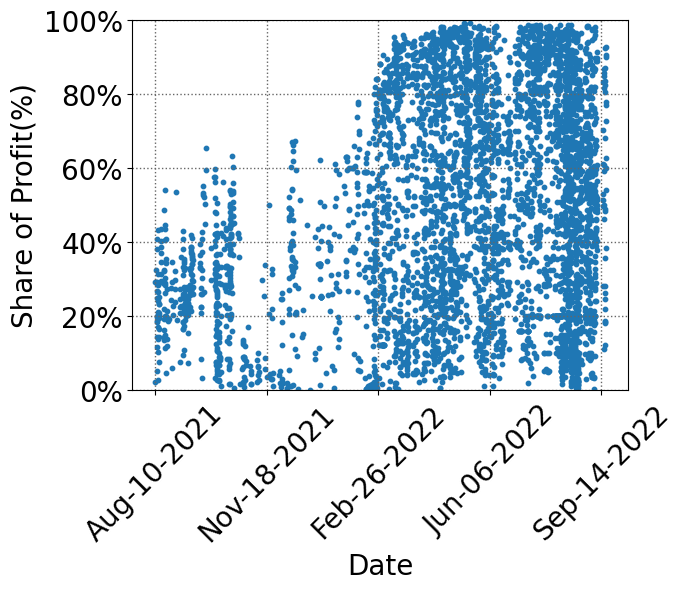

In [2]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll.csv")
df=df[df["coinbase_transfer_usd"]>0]
df=df[df["pureRevenue_usd"]>0]
df=df[df["revenue_dollar"]>0]

minDate=datetime.datetime.fromtimestamp( min(df["timestamp"]) )
maxDate=datetime.datetime.fromtimestamp( max(df["timestamp"]) )
print("max timestamp",max(df["timestamp"]))

timestampMap={}
for index,row in df.iterrows():
    transactionHash=row["transactionHash"]
    timestamp=int(row["timestamp"])
    timestamp=timestamp_removeHour_reduce(timestamp)
    
    coinbase_transfer_usd=float(row["coinbase_transfer_usd"])
    pureRevenue_usd=float(row["pureRevenue_usd"])    
    proportion=(coinbase_transfer_usd/pureRevenue_usd)

    
    if timestamp not in timestampMap:
        timestampMap_value=[]
    else:
        timestampMap_value=timestampMap[timestamp]
    timestampMap_value.append(proportion)
    timestampMap[timestamp]=timestampMap_value
    
list_key=[]
list_key_quchong=[]
list_value=[]
for tempTimestamp in max_min_2_timestampList_day(minDate,maxDate):
    if tempTimestamp>=1663560000:
        break
    dateString=timestamp_2_string_ymd(tempTimestamp)
    list_key_quchong.append(tempTimestamp)
    
    if tempTimestamp not in timestampMap:
        timestampMap[tempTimestamp]=[]
        list_key.append(tempTimestamp)
        list_value.append(-100)
    else:
        length=len(timestampMap[tempTimestamp])
        list_key.extend( length*[tempTimestamp] )
        list_value.extend(timestampMap[tempTimestamp])
        

x=[]
x_key=[]
for i in range(len(list_key_quchong)):
    timestamp=list_key_quchong[i]
    if i%100==0:
        x.append(timestamp)
        x_key.append(timestamp_2_string_ymd(timestamp))


plt.scatter( list_key ,  list_value, s=10)
plt.ylim(0,1)
plt.xticks(x,labels=x_key,fontsize=20,rotation=45)
plt.yticks(fontsize=20)
plt.ylabel('Share of Profit(%)', fontsize=20)
plt.xlabel('Date', fontsize=20)
from matplotlib.ticker import PercentFormatter


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.grid(True, color='#666666', linestyle = ":", linewidth = "1")

plt.savefig("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/photo/mevImpact_shareProfit.pdf",bbox_inches='tight')

# 累计收益

In [3]:
import pandas as pd
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll_final.csv")
df=df[df["revenue_dollar"]>df["minerReward_usd"]]
print("len df",len(df))
print("total revenue",sum(df["revenue_dollar"]))



blockMap={}
for index,row in df.iterrows():
    blockNumber=int(row["blockNumber"])
    minerReward_usd=float(row["minerReward_usd"])
    blockMap[blockNumber]=minerReward_usd
    
print("total minerReward_usd",sum(blockMap.values()))
print("block num",len(blockMap))
    


len df 633
total revenue 7652038.560240254
total minerReward_usd 1160690.3094796622
block num 590


In [114]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll_final.csv")
# df=df[df["coinbase_transfer_usd"]>0]
# df=df[df["pureRevenue_usd"]>0]
df=df[df["revenue_dollar"]>df["minerReward_usd"]]
df["behaviorType"].value_counts()
print(len(df))
print("total revenue",sum(df["revenue_dollar"]))

633
total revenue 7652038.560240254


list_value[-1] 7644994.907729833
list_value[-1] 790382.6815203666
list_value[-1] 1208836.022282495


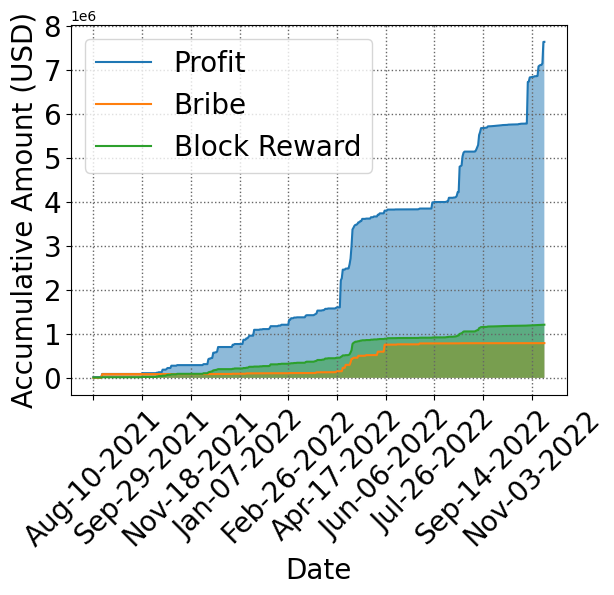

In [117]:
df=pd.read_csv("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/csv/combineAll_final.csv")
# df=df[df["coinbase_transfer_usd"]>0]
# df=df[df["pureRevenue_usd"]>0]
df=df[df["revenue_dollar"]>df["minerReward_usd"]]

timestamp_map={}
for index,row in df.iterrows():
    transactionHash=row["transactionHash"]
    timestamp=int(row["timestamp"])
    
    timestamp=timestamp_removeHour_reduce(timestamp)
    
    coinbase_transfer_usd=float(row["coinbase_transfer_usd"])
    pureRevenue_usd=float(row["pureRevenue_usd"])
    revenue_dollar=float(row["revenue_dollar"])
    minerReward_usd=float(row["minerReward_usd"])
    
    if timestamp not in timestamp_map:
        timestamp_map_value={"pureRevenue_usd":pureRevenue_usd,"coinbase_transfer_usd":coinbase_transfer_usd,
                             "revenue_dollar":revenue_dollar,"minerReward_usd":minerReward_usd}
    else:
        timestamp_map_value=timestamp_map[timestamp]
        timestamp_map_value["pureRevenue_usd"]+=pureRevenue_usd
        timestamp_map_value["coinbase_transfer_usd"]+=coinbase_transfer_usd
        timestamp_map_value["revenue_dollar"]+=revenue_dollar
        timestamp_map_value["minerReward_usd"]+=minerReward_usd
    timestamp_map[timestamp]=timestamp_map_value
    

def plotData(df,timestamp_map,keyType,label):
    list_key=[]
    list_value=[]
    minDate=datetime.datetime.fromtimestamp( min(df["timestamp"]) )
    maxDate=datetime.datetime.fromtimestamp( max(df["timestamp"]) )

    for tempTimestamp in max_min_2_timestampList_day(minDate,maxDate):
        if tempTimestamp not in timestamp_map:
            timestamp_map[tempTimestamp]={"pureRevenue_usd":0,"coinbase_transfer_usd":0,"revenue_dollar":0,"minerReward_usd":0}
        
        list_key.append(timestamp_2_string_ymd(tempTimestamp))
        list_value.append( timestamp_map[tempTimestamp][keyType] )

    count=0
    for key,value in timestamp_map.items():
        if value!=0:
            count+=1
    # print("len of unequal zero: ",count)
    # print("total len: ",len(timestamp_map))

    list_value=np.cumsum(list_value)
    print("list_value[-1]",list_value[-1])
    minItem=0
    for i in range(len(list_value)):
        if list_value[i]>minItem:
            minItem=list_value[i]
            break
        
    for i in range(len(list_value)):
        if list_value[i]==0:
            list_value[i]=minItem

    plt.plot(list_value,label=label)
    plt.fill_between(list_key, 0, list_value, alpha=0.5)
    
num=50
x=[]
x_key=[]
for i in range(len(list_key)):
    if i%50==0:
        x.append(i)
        x_key.append(list_key[i])

    
plotData(df,timestamp_map,"revenue_dollar", "Profit")
plotData(df,timestamp_map,"coinbase_transfer_usd", "Bribe")
plotData(df,timestamp_map,"minerReward_usd", "Block Reward")

plt.legend(fontsize=20)
plt.xticks(x,labels=x_key,fontsize=20,rotation=45)
plt.yticks(fontsize=20)
plt.grid(True, color='#666666', linestyle = ":", linewidth = "1")
plt.fill_between(list_key, 0, list_value, alpha=0.5)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Accumulative Amount (USD)',fontsize=20)

plt.savefig("/mnt/sde1/geth/nft_analyse_v1/data/mevImpact/photo/mevImpact_value.pdf",bbox_inches='tight')
